<a href="https://colab.research.google.com/github/Kagev/DataScience/blob/main/DS_HW_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [ ]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 10000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 256 # кількість нейронів 1-го шару
n_hidden_2 = 512 # кількість нейронів 2-го шару

In [ ]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# type(x_train), type(y_train), type(x_test), type(y_test)

In [ ]:
# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# x_train, x_test

In [ ]:
# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# x_train.shape, x_train[0]

In [ ]:
# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# x_train[0]

In [ ]:
# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)
# train_data

In [ ]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
      super().__init__(name=name)
      self.w = tf.Variable(
          tf.random.normal([in_features, out_features]), name="w"
      )
      self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
      y = tf.matmul(x, self.w) + self.b
      if activation != 0:
          return tf.nn.softmax(y)
      else:
          return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(num_features, n_hidden_1, name='layer1')
    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, name='layer2')
    # Вихідний шар
    self.out_layer = DenseLayer(n_hidden_2, num_classes, name='out_layer')


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer1(x, activation=0)
    x = self.layer2(x, activation=0)
    x = self.out_layer(x, activation=1)

    return x

In [ ]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
  # Закодувати етикетку в один гарячий вектор.
  y_true = tf.one_hot(y_true, depth=num_classes)

  # Значення передбачення кліпу, щоб уникнути помилки log(0).
  y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

  # Обчислення крос-ентропії
  return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
  # Порівнюємо передбачені значення з істинними мітками
  correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
  # Обчислюємо середню точність з використанням згортання
  return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables

    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [ ]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
      pred = neural_net(batch_x)
      loss = cross_entropy(pred, batch_y)
      acc = accuracy(pred, batch_y)
      loss_history.append(loss)
      accuracy_history.append(acc)
      print(f"Крок: {step}, Функція втрат: {loss}, Точність: {acc}")

Крок: 100, Функція втрат: 1161.0775146484375, Точність: 0.66015625
Крок: 200, Функція втрат: 1163.9853515625, Точність: 0.6875
Крок: 300, Функція втрат: 620.34765625, Точність: 0.7421875
Крок: 400, Функція втрат: 212.8118896484375, Точність: 0.78515625
Крок: 500, Функція втрат: 154.5399169921875, Точність: 0.8515625
Крок: 600, Функція втрат: 150.9798126220703, Точність: 0.8828125
Крок: 700, Функція втрат: 105.18000793457031, Точність: 0.91015625
Крок: 800, Функція втрат: 144.5270538330078, Точність: 0.84765625
Крок: 900, Функція втрат: 104.85234832763672, Точність: 0.9140625
Крок: 1000, Функція втрат: 108.87263488769531, Точність: 0.89453125
Крок: 1100, Функція втрат: 78.90072631835938, Точність: 0.90234375
Крок: 1200, Функція втрат: 103.1746826171875, Точність: 0.8984375
Крок: 1300, Функція втрат: 89.93386840820312, Точність: 0.9140625
Крок: 1400, Функція втрат: 61.37238311767578, Точність: 0.953125
Крок: 1500, Функція втрат: 97.24908447265625, Точність: 0.91015625
Крок: 1600, Функція

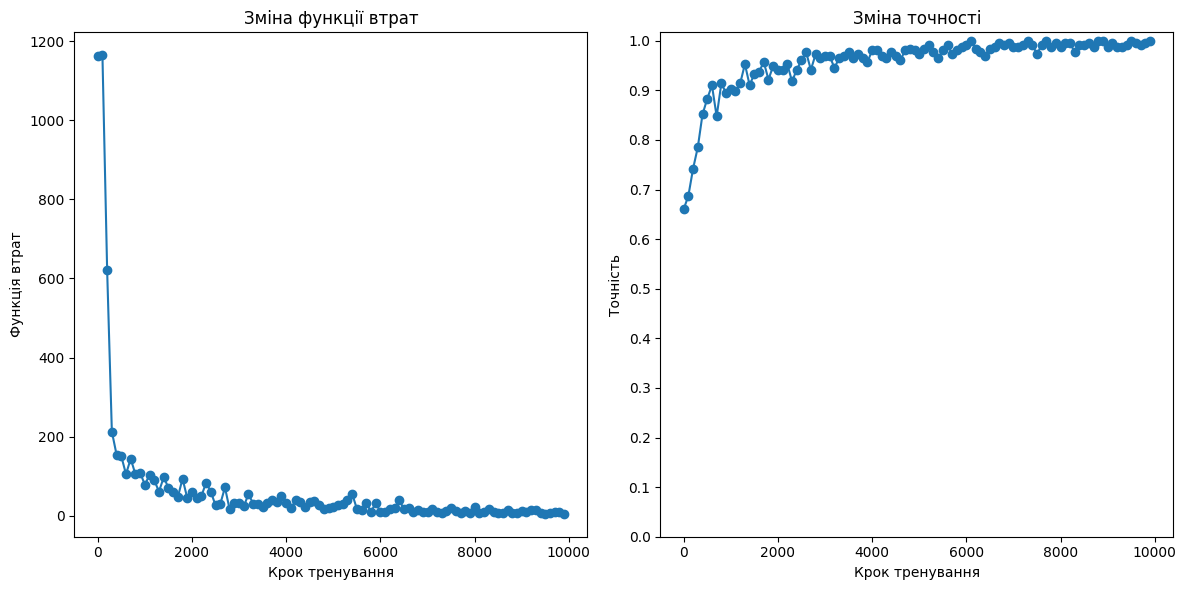

In [ ]:
# Виведи графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведення графіка функції втрат
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, training_steps + 1, display_step), loss_history, marker='o', linestyle='-')
plt.title('Зміна функції втрат')
plt.xlabel('Крок тренування')
plt.ylabel('Функція втрат')

# Виведення графіка точності
plt.subplot(1, 2, 2)
plt.plot(range(1, training_steps + 1, display_step), accuracy_history, marker='o', linestyle='-')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.title('Зміна точності')
plt.xlabel('Крок тренування')
plt.ylabel('Точність')

plt.tight_layout()
plt.show()


In [ ]:
# Обчисли точність навченої нейромережі

# Тестування моделі на тестових даних
test_pred = neural_net(x_test)
print(f"Точність на тестових даних: {accuracy(test_pred, y_test)*100:.2f}%")

Точність на тестових даних: 92.48%


In [ ]:
# Вивід метрик для кожного класу
classes = tf.unique(y_test).y.numpy().sort()
y_pred = tf.argmax(test_pred, axis=1)
print(f"Метрики для кожного класу тестових данних:\n\n {classification_report(y_test, y_pred, labels=classes)}")

Метрики для кожного класу тестових данних:

               precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.98      0.98      0.98      1135
           2       0.92      0.91      0.91      1032
           3       0.91      0.92      0.91      1010
           4       0.91      0.91      0.91       982
           5       0.92      0.90      0.91       892
           6       0.95      0.94      0.95       958
           7       0.94      0.91      0.93      1028
           8       0.88      0.89      0.88       974
           9       0.89      0.90      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



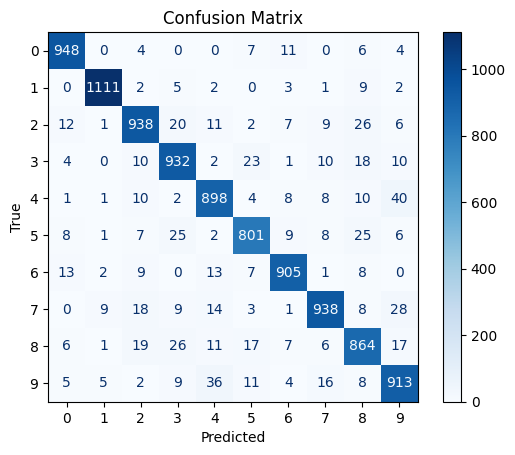

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', values_format='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

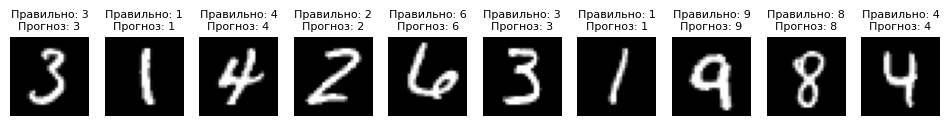

Точність на цих 10 зображеннях: 100.00%


In [ ]:
# Протестуємо навчену нейромережу на 10 зображеннях. З тестової вибірки візьми 5
# випадкових зображень і передай їх у нейронну мережу.
# Виведи зображення та випиши поруч відповідь нейромережі.
# Зроби висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

import random

# Виберемо 5 випадкових зображень з тестової вибірки
random_indices = random.sample(range(len(x_test)), 10)
test_images = x_test[random_indices]
test_labels = y_test[random_indices]

# Прогнозуємо класи для вибраних зображень
predictions = neural_net(test_images)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

# Виведемо зображення та випишемо поруч відповідь нейромережі
plt.figure(figsize=(12, 6))
for i in range(10):
  plt.subplot(1, 10, i + 1)
  plt.imshow(test_images[i].reshape((28, 28)), cmap='gray')
  plt.title(f"Правильно: {test_labels[i]}\nПрогноз: {predicted_labels[i]}", fontsize = 8)
  plt.axis('off')

plt.show()

# Порівняємо прогнози з правильними мітками та обчислимо точність
correct_predictions = (predicted_labels == test_labels)
accuracy = sum(correct_predictions) / len(correct_predictions)
print(f"Точність на цих 10 зображеннях: {accuracy * 100:.2f}%")


Дана модель при параметрах
n_hidden_1 = 128,
n_hidden_2 = 256,
learning_rate = 0.001,
training_steps >= 3000,
має точність > 90% при прогнозуванні тестових даних.

Збільшивши кількість нейронів до n_hidden_1 = 256, n_hidden_2 = 512 зміна точності становить > 95%, однак на тестових даних значення точності лише 91%. Можливо це повязано з перенавчанням моделі і для покращення результату розпізнавання рукописного тексту потрібно використати якісь додаткові алгоритми.